<!-- @format -->

# 1 创建项目环境步骤

- 1、安装 anaconda，并配置环境变量
- 2、创建虚拟环境 conda create -n myenv python=3.9
- 3、激活虚拟环境 conda activate myenv
- 4、安装相关包 pip install -r requirements.txt


<!-- @format -->

# 2 数据准备


<!-- @format -->

## 2.1 导入必要库和包


In [240]:
import pandas as pd
import numpy as np
from joblib import dump, load
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

<!-- @format -->

# 字段说明
- 背景描述
平均医疗费用分析
检查平均医疗费用和影响因素的分析

- 数据说明
在一个医疗保健日益增加的世界里，许多人对他们个人的平均成本是多少，以及导致它的原因是什么。该分析根据变量检查了几个问题：年龄、性别、BMI、排名、吸烟状况、儿童数量、地区和费用。

| 字段名   | 描述                             |
|----------|----------------------------------|
| age      | 年龄                             |
| sex      | 性别（female 或 male）           |
| bmi      | 身体质量指数                     |
| ranking  | 体重等级（overweight, obesity, healthy weight） |
| children | 子女数量                         |
| smoker   | 是否吸烟（yes 或 no）            |
| region   | 居住地区（southwest, southeast, northwest, northeast） |
| charges  | 医疗费用                         |


In [241]:
# 读取csv格式数据，header=0表示第一行是列名，encoding='utf-8'表示使用utf-8编码
df = pd.read_csv('medical_insurance_data_cleaned_rev.csv',header=0)
df.head(1)


,age,sex,bmi,ranking,children,smoker,region,charges
0,19,female,27.9,overweight,0,yes,southwest,16884.92


<!-- @format -->

## 2.3 对数据进行初步探索，包括查看数据集的形状，数据类型，缺失值情况等。


In [242]:
# 显示数据集的形状，即数据集中样本的数量和特征的数量。
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   ranking   1328 non-null   object 
 4   children  1337 non-null   int64  
 5   smoker    1337 non-null   object 
 6   region    1337 non-null   object 
 7   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(4)
memory usage: 83.7+ KB


In [243]:
# 统计各类特征的数据的缺失值情况
print("数据缺失情况:")
print(df.isnull().sum())
print("*"*80)

# 计算每个特征的缺失值占总样本量的比例
missing_values_count = df.isnull().sum()
missing_values_ratio = missing_values_count / len(df) * 100
print("数据缺失比例情况:")
print(missing_values_ratio)
print("*"*80)

# 统计重复样本的个数
duplicate_count = df.duplicated().sum()
print("数据重复情况:",duplicate_count)
print("*"*80)

数据缺失情况:
age         0
sex         0
bmi         0
ranking     9
children    0
smoker      0
region      0
charges     0
dtype: int64
********************************************************************************
数据缺失比例情况:
age         0.000000
sex         0.000000
bmi         0.000000
ranking     0.673149
children    0.000000
smoker      0.000000
region      0.000000
charges     0.000000
dtype: float64
********************************************************************************
数据重复情况: 0
********************************************************************************


<!-- @format -->

# 3 数据预处理


<!-- @format -->

## 3.1 文本标签映射


In [244]:
# 特征矩阵，不包含目标变量。df中去除target列以外的列就是特征。
# id列在建模时没有作用，直接删除
X = df.drop(['charges'], axis=1) 
columns = X.columns
# df的label列是目标变量
y = df['charges']

<!-- @format -->

## 3.2 划分训练集和验证集


In [245]:
# train_test_split用于划分训练集和验证集
# test_size=0.3 这个参数就代表30%的样本做验证集,一般训练集和测试集的比例是7:3或者8:2
# random_state参数设置随机数种子，保证每次切分运行结果一致。
# 因为该数据集效果太好，所以测试集比例大一点，可视化效果好一点
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("训练集样本数量：", X_train.shape[0])
print("测试集样本数量：", X_test.shape[0])

训练集样本数量： 1069
测试集样本数量： 268


<!-- @format -->

## 3.3 针对不同特征进行编码和缺失值处理


In [246]:
# 检测特征数据的类型，将分类特征数据进行编码
# categorical_features用于存储分类型特征字段名称
categorical_features = [] 
# continuous_features用于存储连续型特征字段名称
continuous_features = []
for column in X.columns:
    # 检查是否为字符串类型（通常为分类特征）
    if df[column].dtype == 'object':
        categorical_features.append(column)
    # 将其他类型视为连续特征
    else:
        continuous_features.append(column)
print("分类特征:", categorical_features)
print("连续特征:", continuous_features)

for column in categorical_features:
    df[column] = df[column].astype(str)

分类特征: ['sex', 'ranking', 'smoker', 'region']
连续特征: ['age', 'bmi', 'children']


In [247]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# 创建预处理器
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', SimpleImputer(strategy='most_frequent'), categorical_features),
        ('num', SimpleImputer(strategy='mean'), continuous_features)
    ])
# 对数据集进行预处理
X_train_imputed = preprocessor.fit_transform(X_train)
X_test_imputed = preprocessor.transform(X_test)

# 将处理后的数据转换回 DataFrame
X_train_imputed = pd.DataFrame(X_train_imputed, columns=continuous_features + categorical_features)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=continuous_features + categorical_features)

# 保存预处理器
with open('./models/imputed_preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

In [248]:
X_train_imputed.isnull().sum()

age         0
bmi         0
children    0
sex         0
ranking     0
smoker      0
region      0
dtype: int64

In [249]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import pickle

# 假设 X_train 和 X_test 是你的训练集和测试集
# categorical_features 是一个包含所有分类特征名称的列表

# 创建训练集和测试集的副本
encoded_train = X_train.copy()
encoded_test = X_test.copy()

# 用于保存每个特征的编码器
encoders = {}
# 用于保存每个特征的映射字典
mapping_dicts = {}

# 确保分类特征的值都是字符串类型
for feature in categorical_features:
    # 将分类特征的值转换为字符串
    encoded_train[feature] = encoded_train[feature].astype(str)
    encoded_test[feature] = encoded_test[feature].astype(str)
    
    # 创建标签编码器
    encoder = LabelEncoder()
    
    # 对训练集进行拟合和转换
    encoder.fit(encoded_train[feature])
    
    # 将训练集中的类别与未知类别合并，确保编码器可以处理未知类别
    unique_classes = list(encoder.classes_) + ['Unknown']
    encoder.classes_ = np.array(unique_classes)
    
    # 对训练集进行转换
    encoded_train[feature] = encoder.transform(encoded_train[feature])
    
    # 对测试集进行转换，处理未知类别
    encoded_test[feature] = encoded_test[feature].apply(lambda x: x if x in encoder.classes_[:-1] else 'Unknown')
    encoded_test[feature] = encoder.transform(encoded_test[feature])
    
    # 保存编码器
    encoders[feature] = encoder
    
    # 提取映射字典
    mapping = {cls: idx for idx, cls in enumerate(encoder.classes_)}
    mapping_dicts[feature] = mapping

# 保存分类特征的映射字典
with open('./models/mapping_dicts.pkl', 'wb') as f:
    pickle.dump(mapping_dicts, f)

# 保存编码器
with open('./models/encoders.pkl', 'wb') as f:
    pickle.dump(encoders, f)

# 现在 encoded_train 和 encoded_test 包含了处理后的特征

In [250]:
# 这就是最后输入到模型中的数据
encoded_train

,age,sex,bmi,ranking,children,smoker,region
1113,23,1,24.51,0,0,0,0
967,21,1,25.75,3,2,0,0
598,52,0,37.53,2,2,0,1
170,63,1,41.47,2,0,0,2
275,47,0,26.60,3,2,0,0
...,...,...,...,...,...,...,...
1095,51,0,34.96,2,2,1,0
1130,27,1,45.90,2,2,0,3
1294,20,1,22.00,0,1,0,3
860,38,0,28.00,3,3,0,3


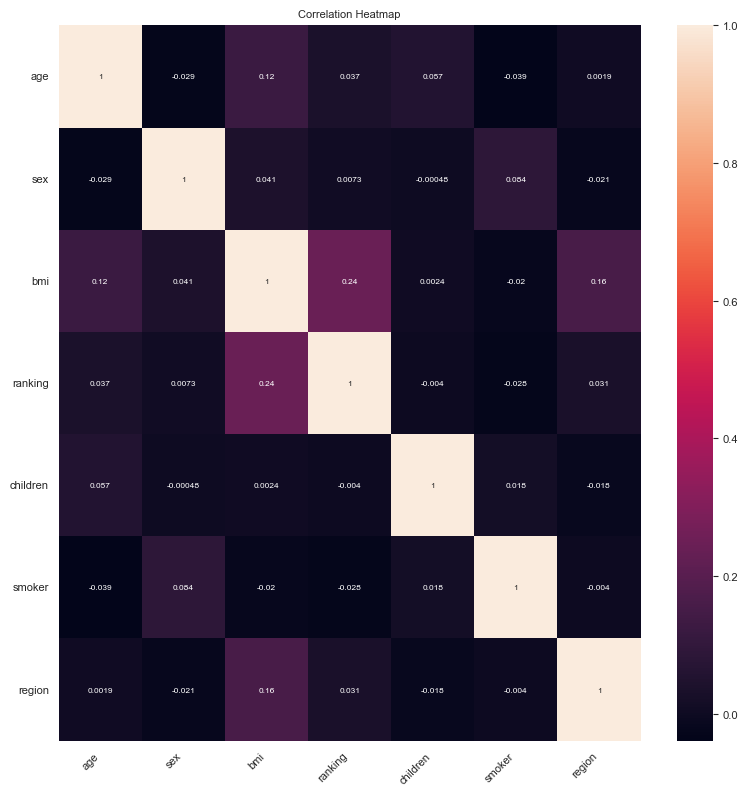

In [251]:
# 设置字体为 Arial（适合科研图表）
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 8  # 设置全局字体大小
plt.figure(figsize=(8, 8))
# 计算相关性矩阵
heat_corr=encoded_train.corr()
sns.heatmap(heat_corr, annot=True, annot_kws={"fontsize": 6})
# 设置标题和字体大小
plt.title('Correlation Heatmap',fontsize=8)
# 设置横坐标角度和字体大小
xticks = plt.xticks()
plt.xticks(xticks[0], xticks[1], rotation=45, ha='right', fontsize=8)
# 设置横坐标字体大小
plt.yticks(fontsize=8,rotation=0) 
# 调整字体避免重叠
plt.tight_layout()
plt.show()

<!-- @format -->

## 3.4 箱线图异常值检测


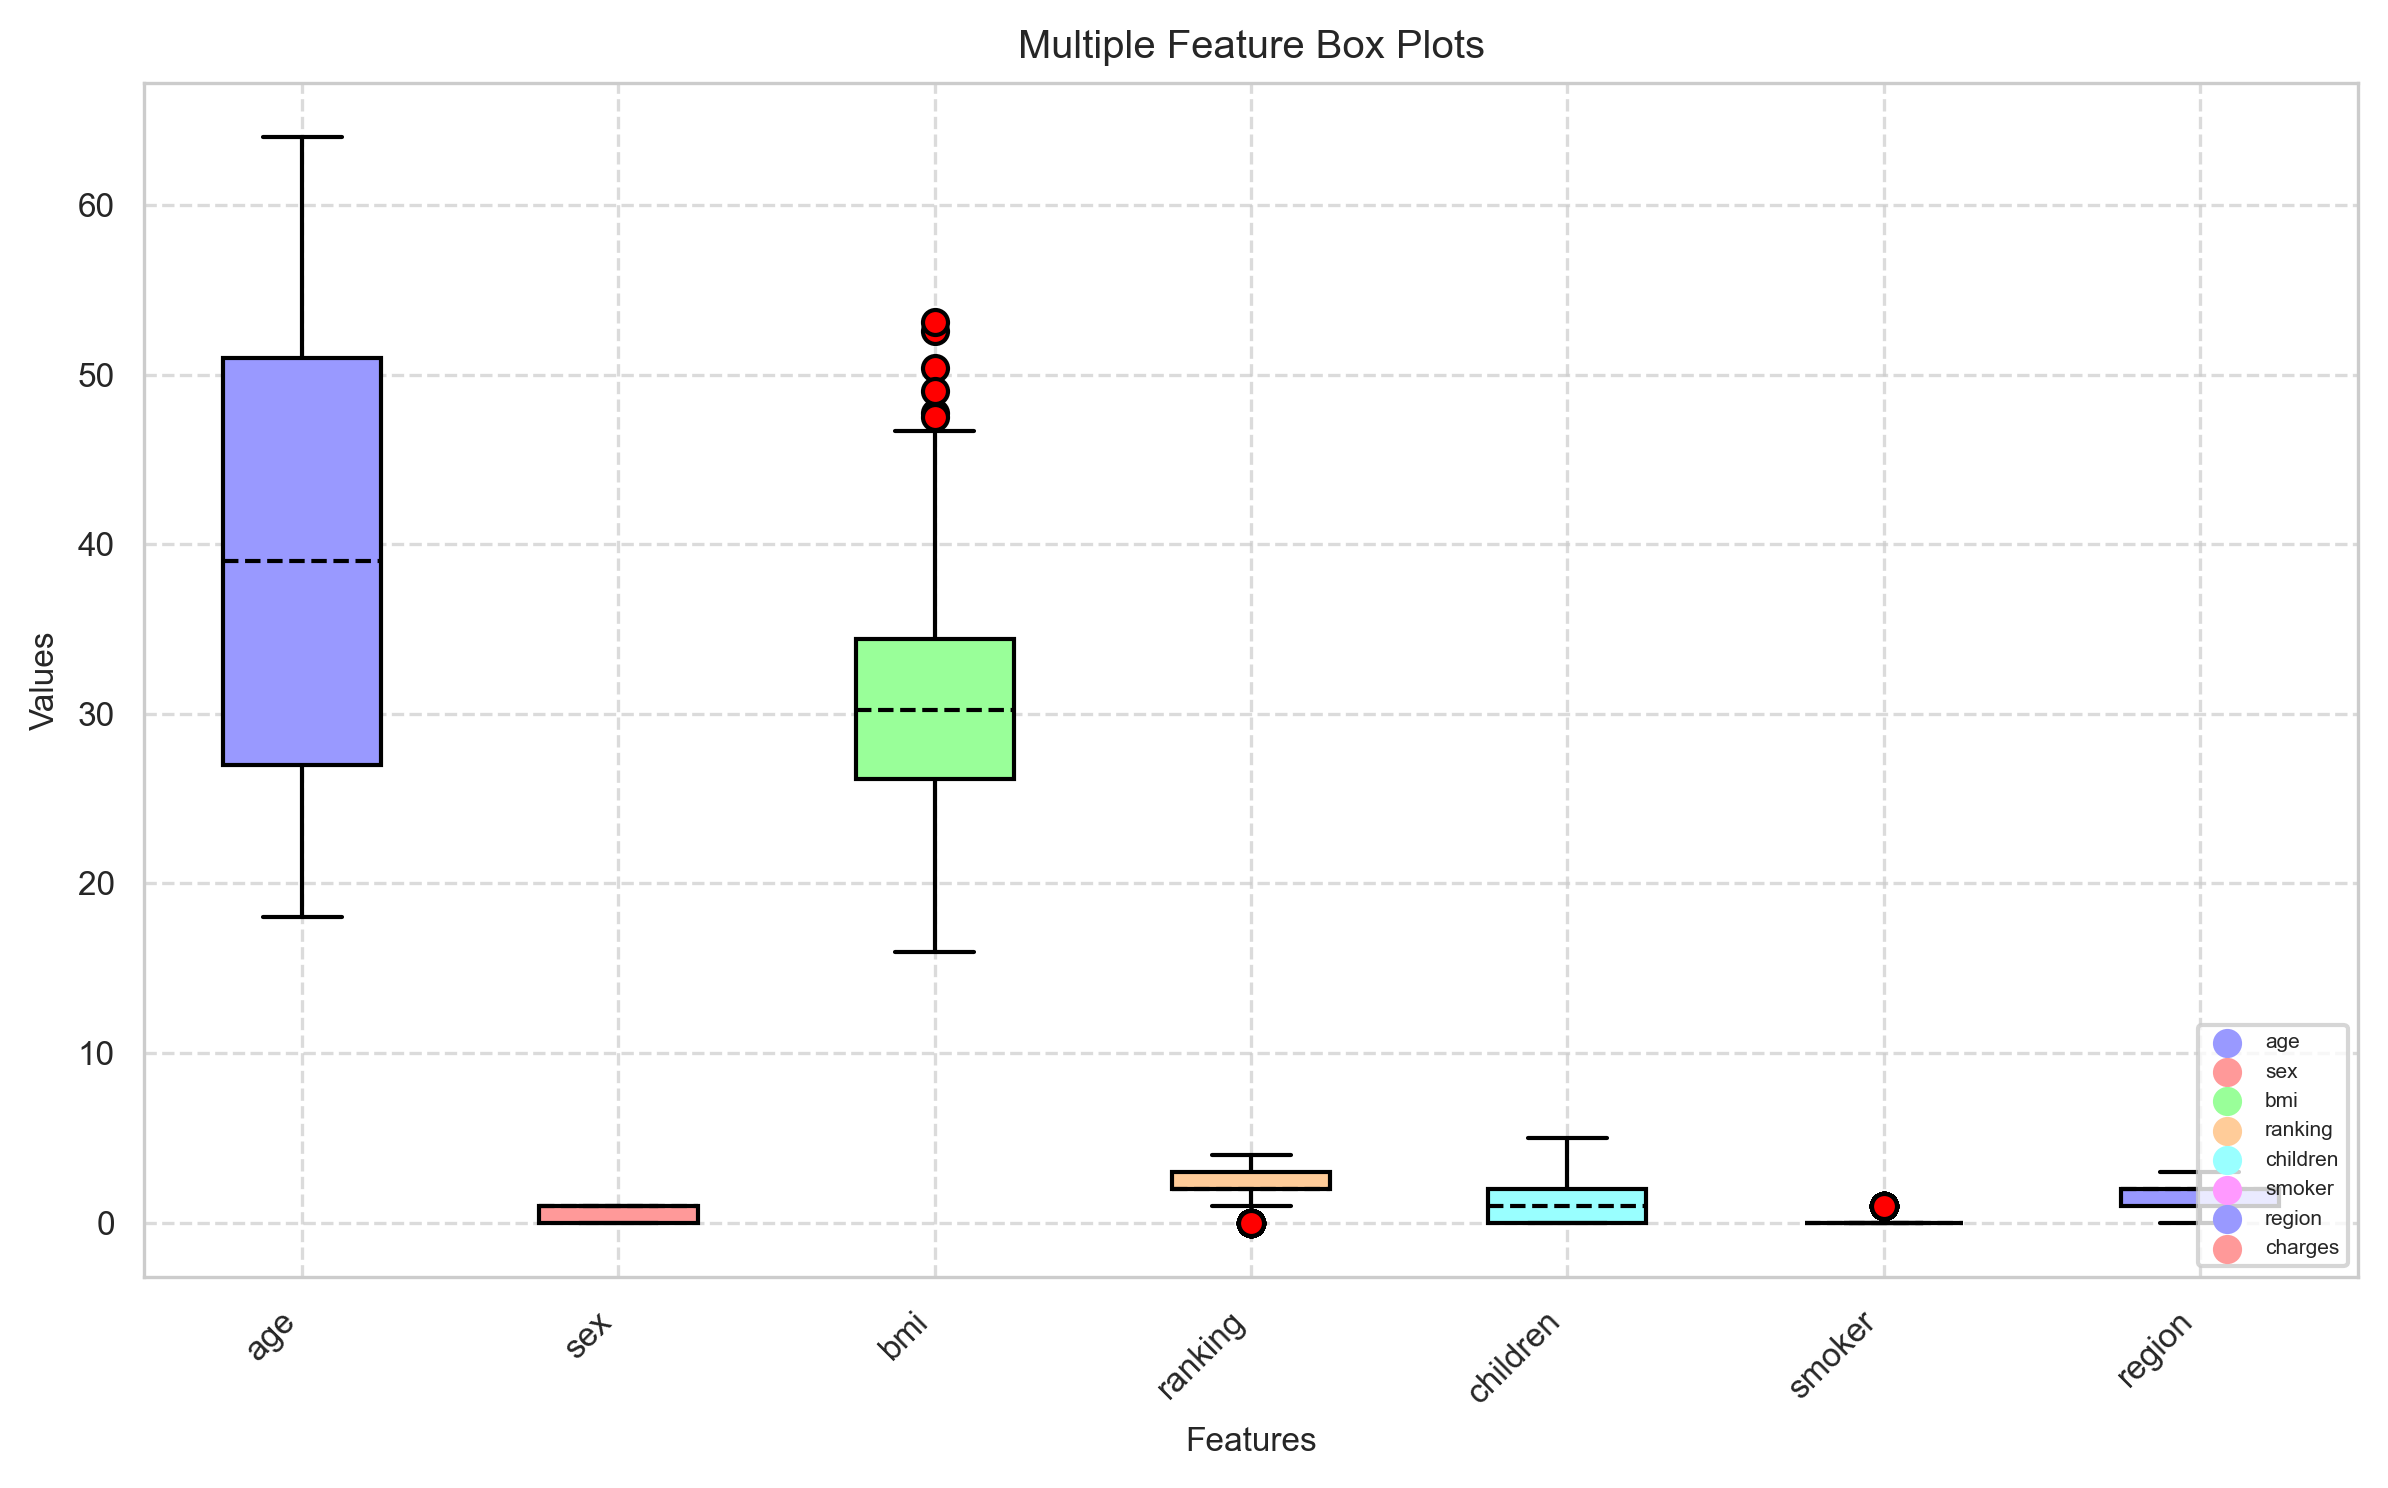

In [252]:
# 标准化和异常值检测的顺序是具体情况而定
# 如果先标准化再检测异常值，那么检测到的异常值会受标准化影响，所以通常先检测异常值，再标准化
# 对训练集通过箱线图进行异常值检测,由于尺度问题，可能一部分特征那个的箱线图会比较集中，看不太出来
# 设置字体和防止中文标签乱码
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
# 创建一个包含多个特征的箱线图
plt.figure(figsize=(8, 5),dpi=300)
sns.set_style("whitegrid")
# 遍历每个特征并绘制箱线图
box_df= encoded_train
colors = ['#9999ff', '#ff9999', '#99ff99', '#ffcc99', '#99ffff', '#ff99ff']
for i, feature in enumerate(box_df.columns):
    plt.boxplot(
        x=box_df[feature],
        widths=0.5,  # 箱线宽度
        positions=[i],  # 设置箱线图的位置
        patch_artist=True,  # 箱体颜色
        # showmeans=True,     # 显示均值
        boxprops={'color': 'black', 'facecolor': colors[i % len(colors)]},  # 设置箱体属性
        flierprops={'marker': 'o', 'markerfacecolor': 'red', 'color': 'black'},  # 设置异常值属性
        # meanprops={'marker': 'o', 'markerfacecolor': 'indianred'},  # 设置均值点的属性
        medianprops={'linestyle': '--', 'color': 'black'}  # 设置中位数线的属性
    )
# 设置标题和标签
plt.title('Multiple Feature Box Plots')
plt.xlabel('Features')
plt.ylabel('Values')
xticks = plt.xticks()
plt.xticks(xticks[0], xticks[1], rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.xticks(ticks=range(len(columns)), labels=columns)  # 设置x轴刻度标签
# 显示网格线
plt.grid(True, linestyle='--', alpha=0.7)
# 添加图例
for i, feature in enumerate(df.columns):
    plt.scatter([], [], c=colors[i % len(colors)], label=feature)
plt.legend(loc='lower right',fontsize=5)
plt.tight_layout()
plt.show()

In [253]:
# # 使用箱线图法剔除异常值
# def remove_outliers_boxplot(df, labels, columns):
#     mask = np.ones(len(df), dtype=bool)
#     for column in columns:
#         Q1 = np.percentile(df[column], 25)
#         Q3 = np.percentile(df[column], 75)
#         IQR = Q3 - Q1
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR
#         mask = mask & (df[column] >= lower_bound) & (df[column] <= upper_bound)
#     outlier_indices = np.where(~mask)[0]  # 获取异常值的索引
#     df_filtered = df[mask]
#     labels_filtered = labels[mask]
#     # 返回结果包括移除异常值后的数据集、标签和异常值的索引
#     return df_filtered, labels_filtered, outlier_indices
# encoded_train, y_train,outlier_indices = remove_outliers_boxplot(box_df.reset_index(drop=True),y_train.reset_index(drop=True),box_df.columns)

<!-- @format -->


<!-- @format -->

## 3.5 数据标准化


In [254]:
# 标准化处理不改变数据的分布，只改变数据尺度
# 通常使用Sklearn库中的StandardScaler对数据进行标准化
from sklearn.preprocessing import StandardScaler
# 初始化StandardScaler对象
scaler = StandardScaler()
# 用训练数据拟合scaler
scaler.fit(encoded_train)
# 转换训练集和验证集 标准化前的格式是dataframe格式，标准化之后转换成numpy格式X_train_scaled
X_train_scaled = scaler.transform(encoded_train)
X_test_scaled = scaler.transform(encoded_test)

# 保存标准化模型
dump(scaler, './models/scaler.joblib')

['./models/scaler.joblib']

<!-- @format -->

选择模型训练的特征，根据需要和意愿选择，此段代码不需要也可忽略


In [255]:
# from sklearn.feature_selection import SelectKBest, f_regression
# # 特征选择：选择与目标变量相关性最高的k个特征
# def select_k_best_features(X, y, columns,k=5):
#     selector = SelectKBest(score_func=f_regression, k=k)
#     X_new = selector.fit_transform(X, y)
#     selected_features = columns[selector.get_support()]
#     return X_new, selected_features

# # 选择5个最佳特征
# X_train_selected, selected_features = select_k_best_features(X_train_scaled, y_train,columns, k=5)
# X_test_selected = pd.DataFrame(X_test_scaled,columns=columns)[selected_features]


<!-- @format -->

# 4 模型训练模块


<!-- @format -->

## 4.1 LinearRegression 线性回归模型训练


线性回归模型均方误差: 35732479.88929016
线性回归模型R²分数: 0.805543946489324


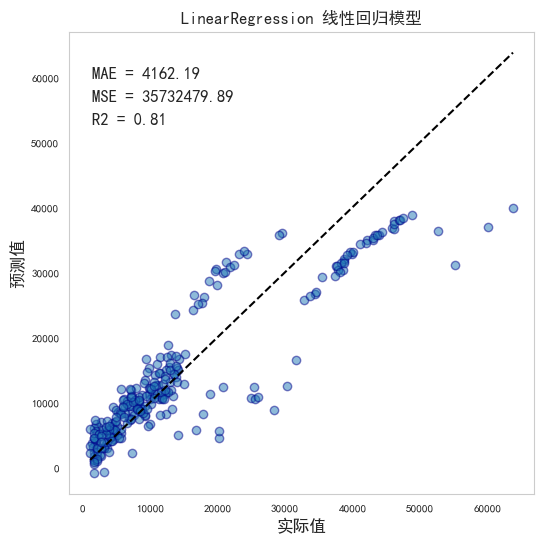

In [256]:
from sklearn.linear_model import LinearRegression

# 初始化线性回归模型
lr_model = LinearRegression()
# 在训练集上训练模型
lr_model.fit(X_train_scaled, y_train)
# 在测试集上进行预测
y_pred_lr = lr_model.predict(X_test_scaled)
# 评估模型性能
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

# 打印模型性能指标
print("线性回归模型均方误差:", mse_lr)
print("线性回归模型R²分数:", r2_lr)

# 可视化预测结果
fig, ax = plt.subplots(figsize=(6, 6))
plt.rcParams['font.sans-serif'] = ['SimHei']  # 或者 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号
# 在图的左上角添加带框的指标文本
MAE = f"MAE = {mae_lr:.2f}"
plt.text(0.05, 0.9, MAE, transform=plt.gca().transAxes, 
         fontsize=12, fontdict={'style': 'italic', 'family': 'SimHei'})
MSE = f"MSE = {mse_lr:.2f}"
plt.text(0.05, 0.85, MSE, transform=plt.gca().transAxes, 
         fontsize=12, fontdict={'style': 'italic', 'family': 'SimHei'})
R2 = f"R2 = {r2_lr:.2f}"
plt.text(0.05, 0.80, R2, transform=plt.gca().transAxes, 
         fontsize=12, fontdict={'style': 'italic', 'family': 'SimHei'})
# 可视化散点图
plt.scatter(y_test, y_pred_lr, alpha=0.5, edgecolor='darkblue', label='测试集数据点')
x_min, x_max = min(y_test.min(), y_test.min()), max(y_test.max(), y_test.max())
ax.plot([x_min, x_max], [x_min, x_max], 'k--')
plt.xlabel("实际值",fontsize=12)
plt.ylabel("预测值",fontsize=12)
plt.title("LinearRegression 线性回归模型",fontsize=12)
plt.grid(False)
plt.savefig('pictures/LinearRegression.png', dpi=300)
plt.show()

<!-- @format -->

## 4.2 Ridge 岭回归模型训练


岭回归模型平均绝对误差: 4162.433526791841
岭回归模型均方误差: 35735781.14384593
岭回归模型R²分数: 0.8055259810714595


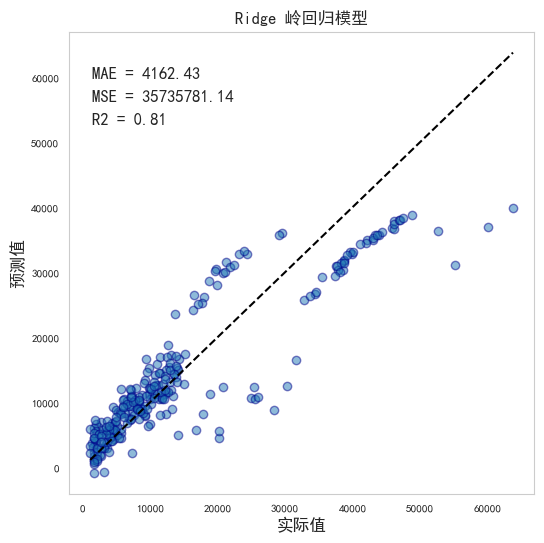

In [257]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 初始化岭回归模型
ridge_model = Ridge(alpha=0.1)  # alpha是正则化强度，可以根据需要调整
# 在训练集上训练模型
ridge_model.fit(X_train_scaled, y_train)
# 在测试集上进行预测
y_pred_ridge = ridge_model.predict(X_test_scaled)
# 评估模型性能
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

# 打印模型性能指标
print("岭回归模型平均绝对误差:", mae_ridge)
print("岭回归模型均方误差:", mse_ridge)
print("岭回归模型R²分数:", r2_ridge)

# 可视化预测结果
fig, ax = plt.subplots(figsize=(6, 6))
plt.rcParams['font.sans-serif'] = ['SimHei']  # 或者 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号
# 在图的左上角添加带框的指标文本
MAE = f"MAE = {mae_ridge:.2f}"
plt.text(0.05, 0.9, MAE, transform=plt.gca().transAxes, 
         fontsize=12, fontdict={'style': 'italic', 'family': 'SimHei'})
MSE = f"MSE = {mse_ridge:.2f}"
plt.text(0.05, 0.85, MSE, transform=plt.gca().transAxes, 
         fontsize=12, fontdict={'style': 'italic', 'family': 'SimHei'})
R2 = f"R2 = {r2_ridge:.2f}"
plt.text(0.05, 0.80, R2, transform=plt.gca().transAxes, 
         fontsize=12, fontdict={'style': 'italic', 'family': 'SimHei'})
# 可视化散点图
plt.scatter(y_test, y_pred_ridge, alpha=0.5, edgecolor='darkblue', label='测试集数据点')
x_min, x_max = min(y_test.min(), y_test.min()), max(y_test.max(), y_test.max())
ax.plot([x_min, x_max], [x_min, x_max], 'k--')
plt.xlabel("实际值", fontsize=12)
plt.ylabel("预测值", fontsize=12)
plt.title("Ridge 岭回归模型", fontsize=12)
plt.grid(False)
plt.savefig('pictures/Ridge岭回归模型.png', dpi=300)
plt.show()

<!-- @format -->

## 4.3 带有交互项的线性回归模型训练


带有交互项的线性回归模型平均绝对误差: 2806.759159292032
带有交互项的线性回归模型均方误差: 20924846.032615162
带有交互项的线性回归模型R²分数: 0.8861270476488694


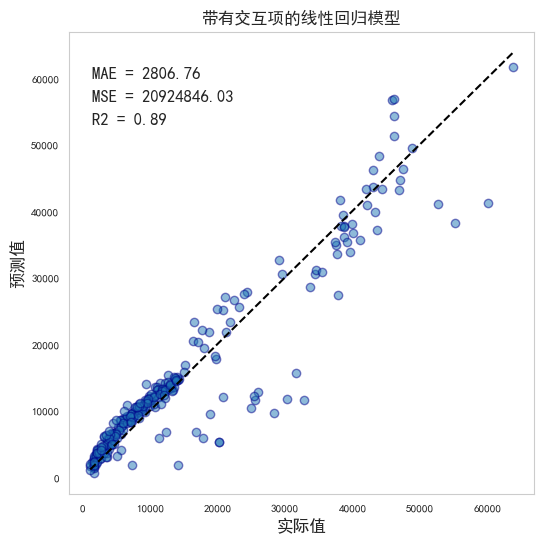

In [258]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 生成交互项和多项式特征
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# 初始化线性回归模型
lr_model = LinearRegression()
# 在训练集上训练模型
lr_model.fit(X_train_poly, y_train)
# 在测试集上进行预测
y_pred_lr = lr_model.predict(X_test_poly)

# 评估模型性能
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

# 打印模型性能指标
print("带有交互项的线性回归模型平均绝对误差:", mae_lr)
print("带有交互项的线性回归模型均方误差:", mse_lr)
print("带有交互项的线性回归模型R²分数:", r2_lr)

# 可视化预测结果
fig, ax = plt.subplots(figsize=(6, 6))
plt.rcParams['font.sans-serif'] = ['SimHei']  # 或者 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号
# 在图的左上角添加带框的指标文本
MAE = f"MAE = {mae_lr:.2f}"
plt.text(0.05, 0.9, MAE, transform=plt.gca().transAxes, 
         fontsize=12, fontdict={'style': 'italic', 'family': 'SimHei'})
MSE = f"MSE = {mse_lr:.2f}"
plt.text(0.05, 0.85, MSE, transform=plt.gca().transAxes, 
         fontsize=12, fontdict={'style': 'italic', 'family': 'SimHei'})
R2 = f"R2 = {r2_lr:.2f}"
plt.text(0.05, 0.80, R2, transform=plt.gca().transAxes, 
         fontsize=12, fontdict={'style': 'italic', 'family': 'SimHei'})
# 可视化散点图
plt.scatter(y_test, y_pred_lr, alpha=0.5, edgecolor='darkblue', label='测试集数据点')
x_min, x_max = min(y_test.min(), y_test.min()), max(y_test.max(), y_test.max())
ax.plot([x_min, x_max], [x_min, x_max], 'k--')
plt.xlabel("实际值", fontsize=12)
plt.ylabel("预测值", fontsize=12)
plt.title("带有交互项的线性回归模型", fontsize=12)
plt.grid(False)
plt.savefig('pictures/带交互项线性回归模型.png', dpi=300)
plt.show()

<!-- @format -->

## 4.4 多项式岭回归模型模型训练


多项式岭回归模型平均绝对误差: 2837.4378306583044
多项式岭回归模型均方误差: 21007032.62016299
多项式岭回归模型R²分数: 0.8856797884741473


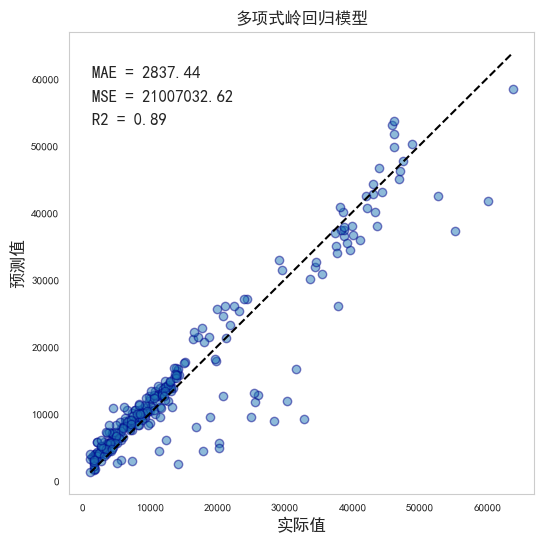

In [259]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 生成多项式特征
degree = 2  # 设置多项式的次数
poly = PolynomialFeatures(degree=degree)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# 初始化岭回归模型
ridge_model = Ridge(alpha=1.0)  # alpha是正则化强度
# 在训练集上训练模型
ridge_model.fit(X_train_poly, y_train)
# 在测试集上进行预测
y_pred_ridge = ridge_model.predict(X_test_poly)

# 评估模型性能
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

# 打印模型性能指标
print("多项式岭回归模型平均绝对误差:", mae_ridge)
print("多项式岭回归模型均方误差:", mse_ridge)
print("多项式岭回归模型R²分数:", r2_ridge)

# 可视化预测结果
fig, ax = plt.subplots(figsize=(6, 6))
plt.rcParams['font.sans-serif'] = ['SimHei']  # 或者 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

# 在图的左上角添加带框的指标文本
MAE = f"MAE = {mae_ridge:.2f}"
plt.text(0.05, 0.9, MAE, transform=plt.gca().transAxes, 
         fontsize=12, fontdict={'style': 'italic', 'family': 'SimHei'})
MSE = f"MSE = {mse_ridge:.2f}"
plt.text(0.05, 0.85, MSE, transform=plt.gca().transAxes, 
         fontsize=12, fontdict={'style': 'italic', 'family': 'SimHei'})
R2 = f"R2 = {r2_ridge:.2f}"
plt.text(0.05, 0.80, R2, transform=plt.gca().transAxes, 
         fontsize=12, fontdict={'style': 'italic', 'family': 'SimHei'})

# 可视化散点图
plt.scatter(y_test, y_pred_ridge, alpha=0.5, edgecolor='darkblue', label='测试集数据点')
x_min, x_max = min(y_test.min(), y_test.min()), max(y_test.max(), y_test.max())
ax.plot([x_min, x_max], [x_min, x_max], 'k--')
plt.xlabel("实际值", fontsize=12)
plt.ylabel("预测值", fontsize=12)
plt.title("多项式岭回归模型", fontsize=12)
plt.grid(False)
plt.savefig('pictures/多项式岭回归模型.png', dpi=300)
plt.show()

<!-- @format -->

## 4.5 CatBoost 回归模型模型训练


0:	learn: 10807.6281848	total: 1.17ms	remaining: 115ms
1:	learn: 10047.8155745	total: 3.37ms	remaining: 165ms
2:	learn: 9421.6352140	total: 5.44ms	remaining: 176ms
3:	learn: 8851.1849822	total: 7.16ms	remaining: 172ms
4:	learn: 8344.7378741	total: 8.91ms	remaining: 169ms
5:	learn: 7877.2834249	total: 10.9ms	remaining: 171ms
6:	learn: 7429.6779578	total: 29.7ms	remaining: 394ms
7:	learn: 7023.0718158	total: 32.3ms	remaining: 371ms
8:	learn: 6711.4591875	total: 35.1ms	remaining: 355ms
9:	learn: 6424.2532973	total: 41.7ms	remaining: 376ms
10:	learn: 6151.4636718	total: 44.1ms	remaining: 357ms
11:	learn: 5900.7773607	total: 45.3ms	remaining: 332ms
12:	learn: 5704.8384322	total: 47.4ms	remaining: 317ms
13:	learn: 5553.2480430	total: 50.2ms	remaining: 309ms
14:	learn: 5401.0913674	total: 52.6ms	remaining: 298ms
15:	learn: 5280.0927187	total: 53.9ms	remaining: 283ms
16:	learn: 5142.2626136	total: 56.2ms	remaining: 275ms
17:	learn: 5035.9539086	total: 58.7ms	remaining: 267ms
18:	learn: 4944.86

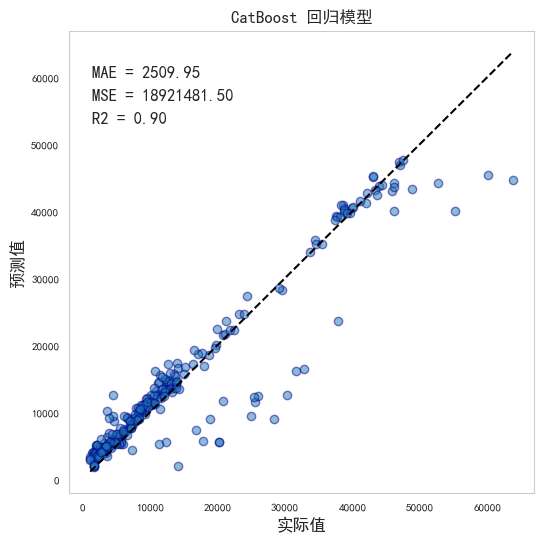

In [260]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 初始化CatBoost回归模型
catboost_model = CatBoostRegressor(
    iterations=100,        # 迭代次数
    learning_rate=0.1,     # 学习率
    depth=6,               # 树的深度
    loss_function='RMSE'   # 损失函数
)

# 在训练集上训练模型
catboost_model.fit(X_train_scaled, y_train)

# 在测试集上进行预测
y_pred_catboost = catboost_model.predict(X_test_scaled)

# 评估模型性能
mae_catboost = mean_absolute_error(y_test, y_pred_catboost)
mse_catboost = mean_squared_error(y_test, y_pred_catboost)
r2_catboost = r2_score(y_test, y_pred_catboost)

# 打印模型性能指标
print("CatBoost回归模型平均绝对误差:", mae_catboost)
print("CatBoost回归模型均方误差:", mse_catboost)
print("CatBoost回归模型R²分数:", r2_catboost)

# 可视化预测结果
fig, ax = plt.subplots(figsize=(6, 6))
plt.rcParams['font.sans-serif'] = ['SimHei']  # 或者 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

# 在图的左上角添加带框的指标文本
MAE = f"MAE = {mae_catboost:.2f}"
plt.text(0.05, 0.9, MAE, transform=plt.gca().transAxes, 
         fontsize=12, fontdict={'style': 'italic', 'family': 'SimHei'})
MSE = f"MSE = {mse_catboost:.2f}"
plt.text(0.05, 0.85, MSE, transform=plt.gca().transAxes, 
         fontsize=12, fontdict={'style': 'italic', 'family': 'SimHei'})
R2 = f"R2 = {r2_catboost:.2f}"
plt.text(0.05, 0.80, R2, transform=plt.gca().transAxes, 
         fontsize=12, fontdict={'style': 'italic', 'family': 'SimHei'})

# 可视化散点图
plt.scatter(y_test, y_pred_catboost, alpha=0.5, edgecolor='darkblue', label='测试集数据点')
x_min, x_max = min(y_test.min(), y_test.min()), max(y_test.max(), y_test.max())
ax.plot([x_min, x_max], [x_min, x_max], 'k--')
plt.xlabel("实际值", fontsize=12)
plt.ylabel("预测值", fontsize=12)
plt.title("CatBoost 回归模型", fontsize=12)
plt.grid(False)
plt.savefig('pictures/catboost_regression.png', dpi=300)
plt.show()

<!-- @format -->

## 4.6 随机森林 RandomForestRegressor 分类模型训练


随机森林回归模型平均绝对误差: 2556.0186718793575
随机森林回归模型均方误差: 20929384.62780965
随机森林回归模型R²分数: 0.8861023486267826


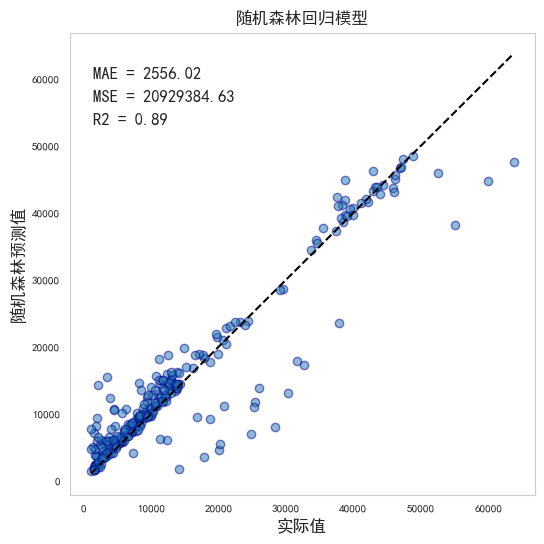

In [261]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 初始化随机森林回归模型
rf_model = RandomForestRegressor(
    n_estimators=100,       # 树的数量
    max_depth=10,           # 树的最大深度
    min_samples_split=2,    # 每个节点分裂所需的最小样本数
    min_samples_leaf=1,     # 每个叶子节点所需的最小样本数
    random_state=42         # 随机种子，确保结果可重复
)

# 在训练集上训练模型
rf_model.fit(X_train_scaled, y_train)

# 在测试集上进行预测
y_pred_rf = rf_model.predict(X_test_scaled)

# 评估模型性能
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# 打印模型性能指标
print("随机森林回归模型平均绝对误差:", mae_rf)
print("随机森林回归模型均方误差:", mse_rf)
print("随机森林回归模型R²分数:", r2_rf)

# 可视化预测结果
fig, ax = plt.subplots(figsize=(6, 6))
plt.rcParams['font.sans-serif'] = ['SimHei']  # 或者 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

# 在图的左上角添加带框的指标文本
MAE = f"MAE = {mae_rf:.2f}"
plt.text(0.05, 0.9, MAE, transform=plt.gca().transAxes, 
         fontsize=12, fontdict={'style': 'italic', 'family': 'SimHei'})
MSE = f"MSE = {mse_rf:.2f}"
plt.text(0.05, 0.85, MSE, transform=plt.gca().transAxes, 
         fontsize=12, fontdict={'style': 'italic', 'family': 'SimHei'})
R2 = f"R2 = {r2_rf:.2f}"
plt.text(0.05, 0.80, R2, transform=plt.gca().transAxes, 
         fontsize=12, fontdict={'style': 'italic', 'family': 'SimHei'})

# 可视化散点图
plt.scatter(y_test, y_pred_rf, alpha=0.5, edgecolor='darkblue', label='测试集数据点')
x_min, x_max = min(y_test.min(), y_test.min()), max(y_test.max(), y_test.max())
ax.plot([x_min, x_max], [x_min, x_max], 'k--')
plt.xlabel("实际值", fontsize=12)
plt.ylabel("随机森林预测值", fontsize=12)
plt.title("随机森林回归模型", fontsize=12)
plt.grid(False)
plt.savefig('pictures/随机森林回归模型.png', dpi=300)

plt.show()

<!-- @format -->

## 4.7 XGBoost 回归模型训练


XGBoost 回归模型平均绝对误差: 2509.491065200122
XGBoost 回归模型均方误差: 18187826.65056335
XGBoost 回归模型R²分数: 0.9010218993094603


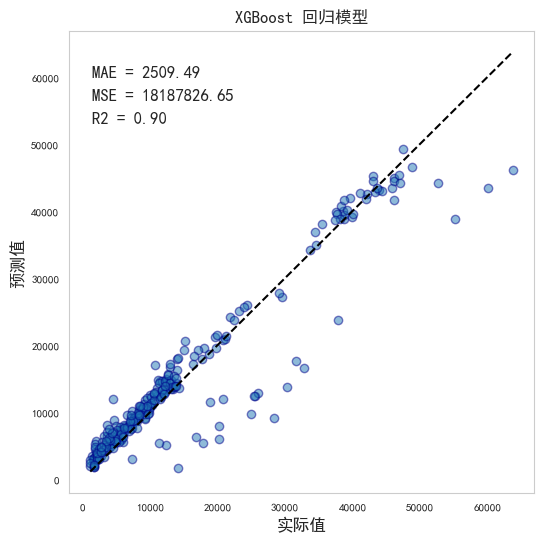

In [262]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 初始化 XGBoost 回归模型
xgb_model = xgb.XGBRegressor(
    n_estimators=100,       # 树的数量
    learning_rate=0.1,      # 学习率
    max_depth=3,            # 树的最大深度
    min_child_weight=1,     # 子节点的最小权重
    gamma=0,                # 控制树的分裂
    subsample=0.8,          # 训练每棵树时使用的数据比例
    colsample_bytree=0.8,   # 训练每棵树时使用的特征比例
    random_state=42         # 随机种子，确保结果可重复
)

# 在训练集上训练模型
xgb_model.fit(X_train_scaled, y_train)

# 在测试集上进行预测
y_pred_xgb = xgb_model.predict(X_test_scaled)

# 评估模型性能
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# 打印模型性能指标
print("XGBoost 回归模型平均绝对误差:", mae_xgb)
print("XGBoost 回归模型均方误差:", mse_xgb)
print("XGBoost 回归模型R²分数:", r2_xgb)

# 可视化预测结果
fig, ax = plt.subplots(figsize=(6, 6))
plt.rcParams['font.sans-serif'] = ['SimHei']  # 或者 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

# 在图的左上角添加带框的指标文本
MAE = f"MAE = {mae_xgb:.2f}"
plt.text(0.05, 0.9, MAE, transform=plt.gca().transAxes, 
         fontsize=12, fontdict={'style': 'italic', 'family': 'SimHei'})
MSE = f"MSE = {mse_xgb:.2f}"
plt.text(0.05, 0.85, MSE, transform=plt.gca().transAxes, 
         fontsize=12, fontdict={'style': 'italic', 'family': 'SimHei'})
R2 = f"R2 = {r2_xgb:.2f}"
plt.text(0.05, 0.80, R2, transform=plt.gca().transAxes, 
         fontsize=12, fontdict={'style': 'italic', 'family': 'SimHei'})

# 可视化散点图
plt.scatter(y_test, y_pred_xgb, alpha=0.5, edgecolor='darkblue', label='测试集数据点')
x_min, x_max = min(y_test.min(), y_test.min()), max(y_test.max(), y_test.max())
ax.plot([x_min, x_max], [x_min, x_max], 'k--')
plt.xlabel("实际值", fontsize=12)
plt.ylabel("预测值", fontsize=12)
plt.title("XGBoost 回归模型", fontsize=12)
plt.grid(False)
plt.savefig('pictures/LightGBM回归模型.png', dpi=300)

plt.show()

<!-- @format -->

## 4.8 lightgbm 回归模型训练


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 327
[LightGBM] [Info] Number of data points in the train set: 1069, number of used features: 7
[LightGBM] [Info] Start training from score 13030.203513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

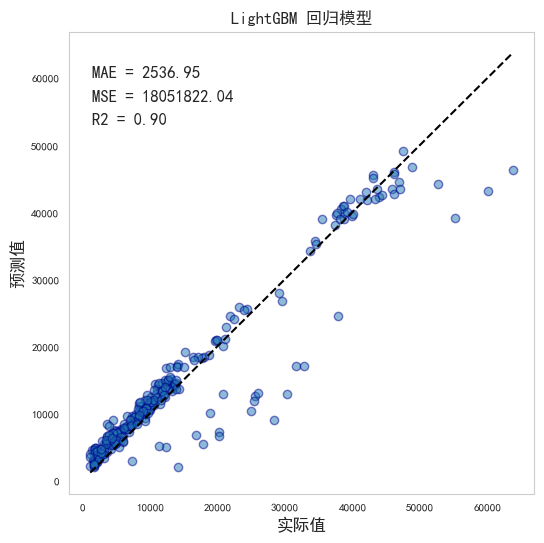

In [263]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 初始化 LightGBM 回归模型
lgb_model = lgb.LGBMRegressor(
    n_estimators=100,       # 树的数量
    learning_rate=0.1,      # 学习率
    max_depth=3,            # 树的最大深度
    num_leaves=31,          # 叶子节点的数量
    subsample=0.8,          # 训练每棵树时使用的数据比例
    colsample_bytree=0.8,   # 训练每棵树时使用的特征比例
    random_state=42         # 随机种子，确保结果可重复
)

# 在训练集上训练模型
lgb_model.fit(X_train_scaled, y_train)

# 在测试集上进行预测
y_pred_lgb = lgb_model.predict(X_test_scaled)

# 评估模型性能
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)

# 打印模型性能指标
print("LightGBM 回归模型平均绝对误差:", mae_lgb)
print("LightGBM 回归模型均方误差:", mse_lgb)
print("LightGBM 回归模型R²分数:", r2_lgb)

# 可视化预测结果
fig, ax = plt.subplots(figsize=(6, 6))
plt.rcParams['font.sans-serif'] = ['SimHei']  # 或者 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

# 在图的左上角添加带框的指标文本
MAE = f"MAE = {mae_lgb:.2f}"
plt.text(0.05, 0.9, MAE, transform=plt.gca().transAxes, 
         fontsize=12, fontdict={'style': 'italic', 'family': 'SimHei'})
MSE = f"MSE = {mse_lgb:.2f}"
plt.text(0.05, 0.85, MSE, transform=plt.gca().transAxes, 
         fontsize=12, fontdict={'style': 'italic', 'family': 'SimHei'})
R2 = f"R2 = {r2_lgb:.2f}"
plt.text(0.05, 0.80, R2, transform=plt.gca().transAxes, 
         fontsize=12, fontdict={'style': 'italic', 'family': 'SimHei'})

# 可视化散点图
plt.scatter(y_test, y_pred_lgb, alpha=0.5, edgecolor='darkblue', label='测试集数据点')
x_min, x_max = min(y_test.min(), y_test.min()), max(y_test.max(), y_test.max())
ax.plot([x_min, x_max], [x_min, x_max], 'k--')
plt.xlabel("实际值", fontsize=12)
plt.ylabel("预测值", fontsize=12)
plt.title("LightGBM 回归模型", fontsize=12)
plt.grid(False)
plt.savefig('./pictures/LightGBM回归.png', dpi=300)
plt.show()

<!-- @format -->

## 4.9 K 近邻回归模型训练


K 近邻回归模型平均绝对误差: 2977.8811343283583
K 近邻回归模型均方误差: 23459881.488483526
K 近邻回归模型R²分数: 0.8723313919377318


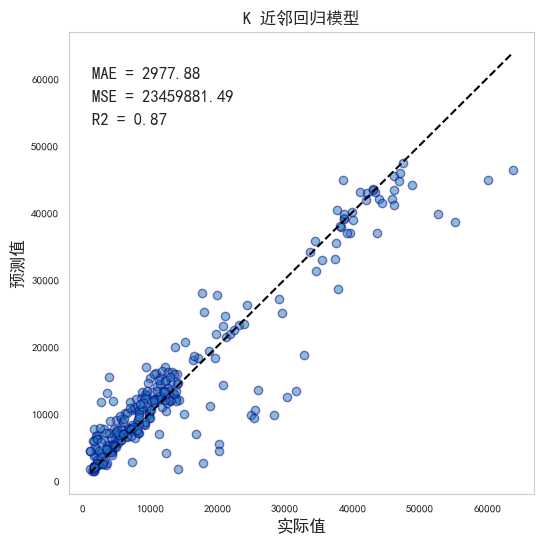

In [264]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 初始化 K 近邻回归模型
knr_model = KNeighborsRegressor(
    n_neighbors=5,  # 邻居数量
    weights='uniform',  # 权重计算方式
    algorithm='auto',  # 算法选择
    leaf_size=30,  # 叶子节点大小
)

# 在训练集上训练模型
knr_model.fit(X_train_scaled, y_train)

# 在测试集上进行预测
y_pred_knr = knr_model.predict(X_test_scaled)

# 评估模型性能
mae_knr = mean_absolute_error(y_test, y_pred_knr)
mse_knr = mean_squared_error(y_test, y_pred_knr)
r2_knr = r2_score(y_test, y_pred_knr)

# 打印模型性能指标
print("K 近邻回归模型平均绝对误差:", mae_knr)
print("K 近邻回归模型均方误差:", mse_knr)
print("K 近邻回归模型R²分数:", r2_knr)

# 可视化预测结果
fig, ax = plt.subplots(figsize=(6, 6))
plt.rcParams['font.sans-serif'] = ['SimHei']  # 或者 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

# 在图的左上角添加带框的指标文本
MAE = f"MAE = {mae_knr:.2f}"
plt.text(0.05, 0.9, MAE, transform=plt.gca().transAxes, 
         fontsize=12, fontdict={'style': 'italic', 'family': 'SimHei'})
MSE = f"MSE = {mse_knr:.2f}"
plt.text(0.05, 0.85, MSE, transform=plt.gca().transAxes, 
         fontsize=12, fontdict={'style': 'italic', 'family': 'SimHei'})
R2 = f"R2 = {r2_knr:.2f}"
plt.text(0.05, 0.80, R2, transform=plt.gca().transAxes, 
         fontsize=12, fontdict={'style': 'italic', 'family': 'SimHei'})

# 可视化散点图
plt.scatter(y_test, y_pred_knr, alpha=0.5, edgecolor='darkblue', label='测试集数据点')
x_min, x_max = min(y_test.min(), y_test.min()), max(y_test.max(), y_test.max())
ax.plot([x_min, x_max], [x_min, x_max], 'k--')
plt.xlabel("实际值", fontsize=12)
plt.ylabel("预测值", fontsize=12)
plt.title("K 近邻回归模型", fontsize=12)
plt.grid(False)
plt.savefig('./pictures/K近邻回归.png', dpi=300)
plt.show()

<!-- @format -->

## 4.10 多层感知机 MLP 回归模型训练


多层感知机回归模型平均绝对误差: 3870.9565991287614
多层感知机回归模型均方误差: 31491250.689169172
多层感知机回归模型R²分数: 0.8286247036840397


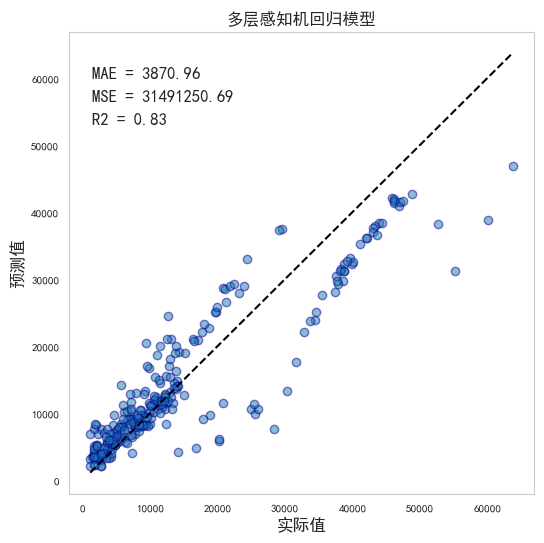

In [265]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 初始化多层感知机回归模型
mlp_model = MLPRegressor(
    hidden_layer_sizes=(100, 50),  # 隐藏层神经元数量
    activation='relu',            # 激活函数
    solver='adam',                # 优化算法
    alpha=0.0001,                 # L2正则化项
    batch_size='auto',            # 批量大小
    learning_rate='constant',     # 学习率
    max_iter=200,                 # 最大迭代次数
    random_state=42               # 随机种子，确保结果可重复
)

# 在训练集上训练模型
mlp_model.fit(X_train_scaled, y_train)

# 在测试集上进行预测
y_pred_mlp = mlp_model.predict(X_test_scaled)

# 评估模型性能
mae_mlp = mean_absolute_error(y_test, y_pred_mlp)
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)

# 打印模型性能指标
print("多层感知机回归模型平均绝对误差:", mae_mlp)
print("多层感知机回归模型均方误差:", mse_mlp)
print("多层感知机回归模型R²分数:", r2_mlp)

# 可视化预测结果
fig, ax = plt.subplots(figsize=(6, 6))
plt.rcParams['font.sans-serif'] = ['SimHei']  # 或者 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

# 在图的左上角添加带框的指标文本
MAE = f"MAE = {mae_mlp:.2f}"
plt.text(0.05, 0.9, MAE, transform=plt.gca().transAxes, 
         fontsize=12, fontdict={'style': 'italic', 'family': 'SimHei'})
MSE = f"MSE = {mse_mlp:.2f}"
plt.text(0.05, 0.85, MSE, transform=plt.gca().transAxes, 
         fontsize=12, fontdict={'style': 'italic', 'family': 'SimHei'})
R2 = f"R2 = {r2_mlp:.2f}"
plt.text(0.05, 0.80, R2, transform=plt.gca().transAxes, 
         fontsize=12, fontdict={'style': 'italic', 'family': 'SimHei'})

# 可视化散点图
plt.scatter(y_test, y_pred_mlp, alpha=0.5, edgecolor='darkblue', label='测试集数据点')
x_min, x_max = min(y_test.min(), y_test.min()), max(y_test.max(), y_test.max())
ax.plot([x_min, x_max], [x_min, x_max], 'k--')
plt.xlabel("实际值", fontsize=12)
plt.ylabel("预测值", fontsize=12)
plt.title("多层感知机回归模型", fontsize=12)
plt.grid(False)
plt.savefig('./pictures/mlp_regression_model.png',dpi=300)
plt.show()

In [266]:
import os

# 指定要搜索的文件夹路径
folder_path = './pictures'  # 替换为你的文件夹路径

png_images = []
# 遍历文件夹中的所有文件和子文件夹
for root, dirs, files in os.walk(folder_path):
    for file in files:
        # 检查文件扩展名是否为.png
        if file.lower().endswith('.png'):
            # 获取文件的完整路径
            png_images.append(os.path.join(root, file))

# 打印结果
print(png_images)

['./pictures\\catboost_regression.png', './pictures\\K近邻回归.png', './pictures\\LightGBM回归.png', './pictures\\LightGBM回归模型.png', './pictures\\LinearRegression.png', './pictures\\mlp_regression_model.png', './pictures\\Ridge岭回归模型.png', './pictures\\多项式岭回归模型.png', './pictures\\带交互项线性回归模型.png', './pictures\\随机森林回归模型.png']


In [267]:

import os
from PIL import Image

# 指定要搜索的文件夹路径
folder_path = './pictures'  # 替换为你的文件夹路径

# 获取文件夹中所有PNG图片的路径列表
png_files = []
for root, dirs, files in os.walk(folder_path):
    for file in files:
        if file.lower().endswith('.png'):
            png_files.append(os.path.join(root, file))

# 确保有正好9张图片
if len(png_files) != 9:
    png_files = png_files[:9]
    # raise ValueError(f"Expected 9 PNG images, but found {len(png_files)}")

# 获取第一张图片的尺寸，假设所有图片尺寸相同
sample_img = Image.open(png_files[0])
img_width, img_height = sample_img.size

# 创建一个新图像用于存放拼接后的图片
# 拼接后的图片宽度和高度是单张图片的3倍
result_img = Image.new('RGB', (img_width * 3, img_height * 3), (255, 255, 255))  # 白色背景

# 将九张图片拼接到结果图像上
for i, img_path in enumerate(png_files):
    img = Image.open(img_path)
    # 计算当前图片的位置
    row = i // 3
    col = i % 3
    result_img.paste(img, (col * img_width, row * img_height))

# 保存或显示拼接后的图片
result_img.show()
# result_img.save('result.png')  # 保存拼接后的图片

<!-- @format -->

# 5 模型调优


<!-- @format -->

## 5.1 引入参数调优的必要模块


In [268]:

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import  mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib

<!-- @format -->

## 5.2 使用 GridSearchCV 寻找最佳参数


0:	learn: 10807.6281848	total: 1.74ms	remaining: 172ms
1:	learn: 10077.3096158	total: 3.5ms	remaining: 172ms
2:	learn: 9439.5452223	total: 4.81ms	remaining: 156ms
3:	learn: 8925.3778223	total: 6.14ms	remaining: 147ms
4:	learn: 8352.2884279	total: 7.5ms	remaining: 142ms
5:	learn: 7923.0487231	total: 8.83ms	remaining: 138ms
6:	learn: 7514.3290687	total: 10.2ms	remaining: 135ms
7:	learn: 7111.1766577	total: 11.4ms	remaining: 131ms
8:	learn: 6755.0404249	total: 12.7ms	remaining: 128ms
9:	learn: 6497.3016139	total: 13.6ms	remaining: 122ms
10:	learn: 6241.3467475	total: 15.5ms	remaining: 126ms
11:	learn: 6009.8742643	total: 16.7ms	remaining: 123ms
12:	learn: 5796.8803252	total: 18.2ms	remaining: 122ms
13:	learn: 5628.0007114	total: 19.4ms	remaining: 119ms
14:	learn: 5466.6148563	total: 20.6ms	remaining: 116ms
15:	learn: 5328.6232012	total: 22.2ms	remaining: 116ms
16:	learn: 5231.6753185	total: 23.2ms	remaining: 113ms
17:	learn: 5143.9456032	total: 24.3ms	remaining: 111ms
18:	learn: 5057.9498

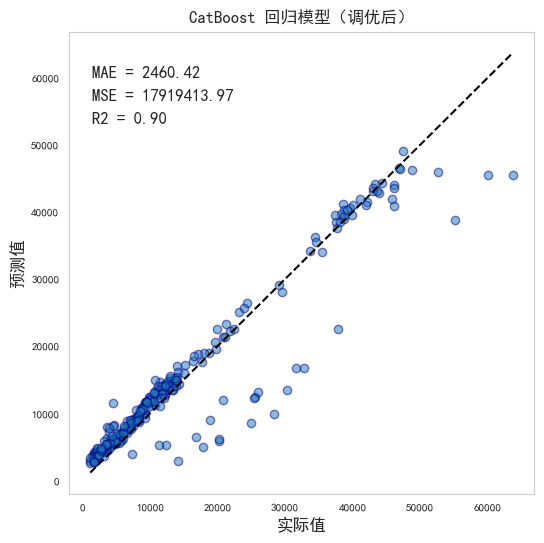

In [269]:


# 初始化CatBoost回归模型
catboost_model = CatBoostRegressor()

# 定义参数网格
param_grid = {
    'iterations': [100, 200],         # 迭代次数
    'learning_rate': [0.01, 0.1, 0.2],# 学习率
    'depth': [4, 6, 8],               # 树的深度
    'loss_function': ['RMSE', 'MAE']  # 损失函数
}

# 创建网格搜索对象
grid_search = GridSearchCV(
    estimator=catboost_model,
    param_grid=param_grid,
    cv=3,                  # 3折交叉验证
    scoring='neg_mean_squared_error',  # 使用负均方误差作为评分标准
    n_jobs=-1              # 使用所有可用的CPU核心
)

# 在训练集上进行网格搜索
grid_search.fit(X_train_scaled, y_train)

# 输出最佳参数组合及其对应的均方误差
print("最佳参数:", grid_search.best_params_)
print("最佳均方误差:", -grid_search.best_score_)
best_model = grid_search.best_estimator_

# 使用最佳模型进行预测
y_pred_catboost = best_model.predict(X_test_scaled)

# 评估最佳模型的性能
mae_catboost = mean_absolute_error(y_test, y_pred_catboost)
mse_catboost = mean_squared_error(y_test, y_pred_catboost)
r2_catboost = r2_score(y_test, y_pred_catboost)

# 打印模型性能指标
print("CatBoost回归模型平均绝对误差:", mae_catboost)
print("CatBoost回归模型均方误差:", mse_catboost)
print("CatBoost回归模型R²分数:", r2_catboost)

# 可视化预测结果
fig, ax = plt.subplots(figsize=(6, 6))
plt.rcParams['font.sans-serif'] = ['SimHei']  # 或者 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

# 在图的左上角添加带框的指标文本
MAE = f"MAE = {mae_catboost:.2f}"
plt.text(0.05, 0.9, MAE, transform=plt.gca().transAxes, 
         fontsize=12, fontdict={'style': 'italic', 'family': 'SimHei'})
MSE = f"MSE = {mse_catboost:.2f}"
plt.text(0.05, 0.85, MSE, transform=plt.gca().transAxes, 
         fontsize=12, fontdict={'style': 'italic', 'family': 'SimHei'})
R2 = f"R2 = {r2_catboost:.2f}"
plt.text(0.05, 0.80, R2, transform=plt.gca().transAxes, 
         fontsize=12, fontdict={'style': 'italic', 'family': 'SimHei'})

# 可视化散点图
plt.scatter(y_test, y_pred_catboost, alpha=0.5, edgecolor='darkblue', label='测试集数据点')
x_min, x_max = min(y_test.min(), y_test.min()), max(y_test.max(), y_test.max())
ax.plot([x_min, x_max], [x_min, x_max], 'k--')
plt.xlabel("实际值", fontsize=12)
plt.ylabel("预测值", fontsize=12)
plt.title("CatBoost 回归模型（调优后）", fontsize=12)
plt.grid(False)
plt.show()

In [270]:
grid_search.best_params_

{'depth': 4, 'iterations': 100, 'learning_rate': 0.1, 'loss_function': 'RMSE'}

<!-- @format -->

## 5.3 使用最佳参数重新训练模型


In [271]:
# 直接保存GridSearchCV训练出的最优模型
joblib.dump(grid_search.best_estimator_, './models/best_regression_model.joblib')

['./models/best_regression_model.joblib']

<!-- @format -->

## 5.4 最佳模型结果可视化


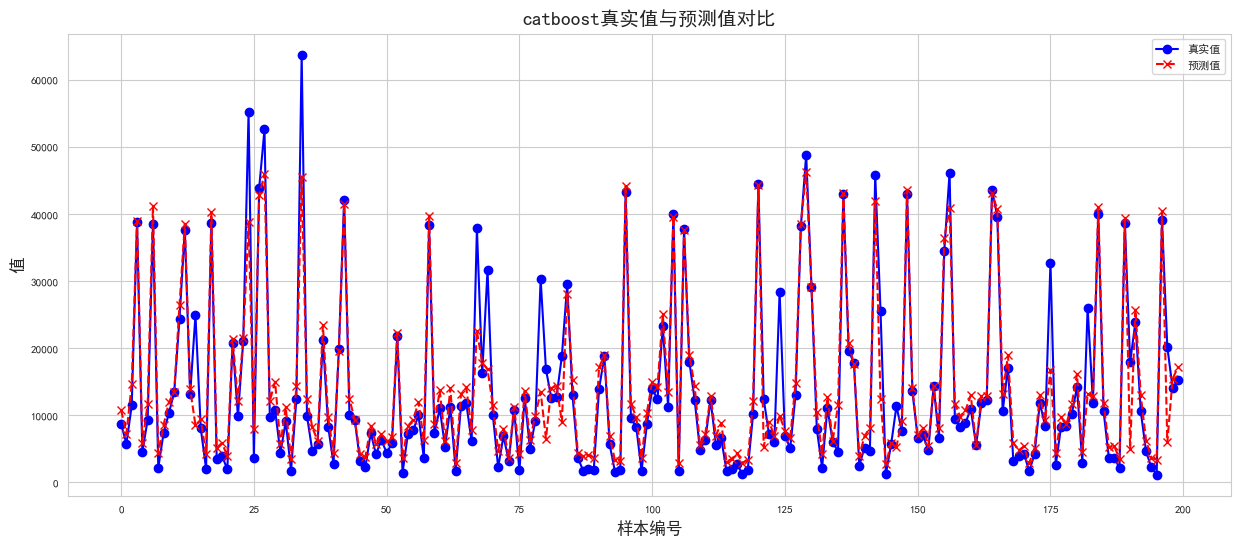

In [272]:
loaded_model = joblib.load('./models/best_regression_model.joblib')
y_pred = loaded_model.predict(X_test_scaled)
# 选出前n个样本进行预测和真实值的对比可视化
import matplotlib.pyplot as plt
n = 200
# 样本编号
sample_indices = list(range(0, n))
# 绘制折线图
plt.figure(figsize=(15, 6))  # 设置图形大小
# 设置Matplotlib支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 或者 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号
plt.plot(sample_indices, y_test.to_list()[:n], marker='o', label='真实值', linestyle='-', color='blue')  # 真实值折线
plt.plot(sample_indices, y_pred.tolist()[:n], marker='x', label='预测值', linestyle='--', color='red')  # 预测值折线
# 添加标题和标签
plt.title('catboost真实值与预测值对比', fontsize=14)
plt.xlabel('样本编号', fontsize=12)
plt.ylabel('值', fontsize=12)
# 添加图例
plt.legend()
# 显示网格
plt.grid(True)
# 显示图形
plt.show()

<!-- @format -->

# 6 最佳模型推理模块


<!-- @format -->

## 6.1 引入模型推理必要的库


In [273]:
import pandas as pd
import numpy as np
from joblib import dump, load
from sklearn.preprocessing import LabelEncoder
import pickle

<!-- @format -->

## 6.2 对推理数据进行编码


In [274]:

# 加载映射字典
with open('./models/mapping_dicts.pkl', 'rb') as f:
    loaded_mapping_dicts = pickle.load(f)

inference_data = pd.read_csv('inference.csv')
# 对推理数据进行编码
encoded_inference = inference_data.copy()
for feature in categorical_features:
    mapping = loaded_mapping_dicts[feature]
    # 处理未知类别
    encoded_inference[feature] = encoded_inference[feature].apply(lambda x: x if x in mapping else 'Unknown')
    # 应用映射字典
    encoded_inference[feature] = encoded_inference[feature].map(mapping)

# print("\n推理数据编码结果:")
# print(encoded_inference)

In [275]:
encoded_inference

,age,sex,bmi,ranking,children,smoker,region,charges
0,19,0,27.90,3,0,1,3,16884.92
1,18,1,33.77,2,1,0,2,1725.55
2,28,1,33.00,2,3,0,2,4449.46
3,33,1,22.71,0,0,0,1,21984.47
4,32,1,28.88,3,0,0,1,3866.86
...,...,...,...,...,...,...,...,...
1332,50,1,30.97,2,3,0,1,10600.55
1333,18,0,31.92,2,0,0,0,2205.98
1334,18,0,36.85,2,0,0,2,1629.83
1335,21,0,25.80,3,0,0,3,2007.95


<!-- @format -->

## 6.3 加载模型进行推理


In [276]:
# 加载数据标准化模块
loaded_scaler = joblib.load('./models/scaler.joblib')
# 对推理数据进行标准化处理
scaled_encoded_inference = loaded_scaler.transform(encoded_inference.drop(['charges'], axis=1))
# 查看标准化后的推理数据
encoded_inference.head()

,age,sex,bmi,ranking,children,smoker,region,charges
0,19,0,27.90,3,0,1,3,16884.92
1,18,1,33.77,2,1,0,2,1725.55
2,28,1,33.00,2,3,0,2,4449.46
3,33,1,22.71,0,0,0,1,21984.47
4,32,1,28.88,3,0,0,1,3866.86


<!-- @format -->

## 6.4 加载模型调优的最佳模型进行模型推理


In [277]:
# 加载最佳模型进行预测
loaded_model = joblib.load('./models/best_regression_model.joblib')
y_pred = pd.DataFrame(loaded_model.predict(scaled_encoded_inference), columns=['Predicted'])

In [278]:
result = pd.concat([inference_data.reset_index(drop=True),y_pred.reset_index(drop=True)], axis=1)
result

,age,sex,bmi,ranking,children,smoker,region,charges,Predicted
0,19,female,27.90,overweight,0,yes,southwest,16884.92,17945.358237
1,18,male,33.77,obesity,1,no,southeast,1725.55,3935.891960
2,28,male,33.00,obesity,3,no,southeast,4449.46,6344.056440
3,33,male,22.71,healthy weight,0,no,northwest,21984.47,5682.713504
4,32,male,28.88,overweight,0,no,northwest,3866.86,4344.790683
...,...,...,...,...,...,...,...,...,...
1332,50,male,30.97,obesity,3,no,northwest,10600.55,12388.091707
1333,18,female,31.92,obesity,0,no,northeast,2205.98,4234.961843
1334,18,female,36.85,obesity,0,no,southeast,1629.83,2700.554730
1335,21,female,25.80,overweight,0,no,southwest,2007.95,3183.084471


<!-- @format -->

## 6.5 对推理结果进行保存


In [279]:
# 保存模型推理结果
result.to_csv('result.csv', index=False)
print('模型推理完毕!!')

模型推理完毕!!


<!-- @format -->

## 6.6 模型推理结果可视化


<!-- @format -->

### 如果需要进行项目的迁移，使用 pip freeze > requirements.txt 生成项目依赖包，

### 使用 pip install -r requirements.txt 安装依赖包
